In [8]:
%matplotlib inline

# Load Model and Weights

In [2]:

import abc
import argparse
import itertools
import pathlib
import multiprocessing as mp
import typing
import os
import matplotlib
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm import tqdm

import utils.utils as utils

from datasets import load_dataset
import numpy as np
import cv2
parser = argparse.ArgumentParser()
parser.add_argument("--threshold", default=0.5, type=float)
parser.add_argument("--resize-width", default=600, type=int)
parser.add_argument("--resize-height", default=None, type=typing.Optional[int])
parser.add_argument("--matcher", default="orb", type=str)  # sift, orb, mse
parser.add_argument("--lowe-ratio", default=0.79, type=float)
parser.add_argument("--mean-distance", default=True, type=bool)  # 0.224719101123595 in success rate
#parser.add_argument("--mean-distance", default=False, type=bool)  # 0.005 in success rate
parser.add_argument("--top-k-matches", default=5, type=int)
args = parser.parse_args("")

if args.matcher == "mse" and not args.mean_distance:
    raise RuntimeError("MSE cannot be used without mean_distance=True")




# Define Image Preprocessing Function


In [3]:
# Function to display the images in the notebook
def display_cv2_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #Show the image with matplotlib
    plt.imshow(image)
    plt.show()

In [42]:
def extract_roi(segmentation, bbox, image_path, resize_width=None, resize_height=None, image_cache=None):
    box = np.asarray(bbox)
    #print("ok")
    mask = np.asarray([segmentation])
    seg_contour = np.reshape(mask, (int(mask.shape[-1] / 2), 2))

    if image_cache and image_path in image_cache:
        orginal_image = image_cache[image_path]
    else:
        orginal_image = cv2.imread(image_path)

    # Resize processes
    if resize_width or resize_height:
        image = utils.image_resize(orginal_image, width=resize_width, height=resize_height)
        seg_contour = utils.contour_resize(seg_contour, orginal_image, image)
        box = utils.bbox_resize(box, orginal_image, image)
    
    x, y, w, h = box

    image_mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.polylines(image_mask, [seg_contour], True, 255, 1)

    # find the external contours
    contours = cv2.findContours(image_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    cnt = contours[0]

    # Fill image mask in the contour area
    cv2.drawContours(image_mask, [cnt], 0, 255, -1)

    # Mask out relevant area
    roi = cv2.bitwise_and(image, image, mask=image_mask)

    # Extract exactly the relevant bbox
    roi = roi[y:y + h, x:x + w]

    return roi


def apply_grayscale_and_filter(img):
    result = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    result = cv2.medianBlur(result, 1)
    #result = cv2.adaptiveThreshold(result, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 1)
    result = cv2.adaptiveThreshold(result, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 10)
    return result

In [5]:

class MSEMatcher():

    def __init__(self):
        pass

    def detectAndCompute(self, image, *args, **kwargs):
        return None, image

    def match(self, image1, image2):
        mse = ((image1 - image2)**2).mean(axis=None)
        return mse

class Matcher:

    def __init__(self):
        self.lowe_ratio = args.lowe_ratio

        if args.matcher == "orb":
            self._detector = cv2.ORB_create()
            self._matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            self._matcher_fn = self._match_orb
            self._draw_fn = self._draw_orb

        elif args.matcher == "sift":
            self._detector = cv2.SIFT_create()
            self._matcher = cv2.BFMatcher()
            self._matcher_fn = self._match_sift
            self._draw_fn = self._draw_sift
        elif args.matcher == "mse":
            self._detector = MSEMatcher()
            self._matcher = self._detector
            self._matcher_fn = self._match_mse
            self._draw_fn = self._draw_mse



    def detect(self, image1, image2):
        # finding key points and descriptors of both images using detectAndCompute() function
        key_point1, descrip1 = self._detector.detectAndCompute(image1, None)
        key_point2, descrip2 = self._detector.detectAndCompute(image2, None)

        try:
            list_of_matches, mean_distance = self._matcher_fn(descrip1, descrip2)
        except Exception as e:
            list_of_matches, mean_distance = [], 90000000

        return len(list_of_matches), list_of_matches, mean_distance, key_point1, key_point2

    def _match_mse(self, des1, des2):
        distance = self._matcher(des1, des2)
        return [], distance

    def _match_sift(self, des1, des2):
        matches = self._matcher.knnMatch(des1,des2,k=2)
        good = []
        for m,n in matches:
            if m.distance < args.lowe_ratio*n.distance:
                good.append([m])

        average_distance = sum([x.distance for x in good]) / len(good)
        return good, average_distance

    def _match_orb(self, des1, des2):
        # Match descriptors.
        matches = self._matcher.match(des1,des2)

        # Sort them in the order of their distance.
        matches = list(sorted(matches, key = lambda x:x.distance))
        matches = matches[:min(len(matches), args.top_k_matches)]

        average_distance = sum([x.distance for x in matches]) / len(matches)


        return matches, average_distance

    def _draw_sift(self, img1, kp1, img2, kp2, matches):
        return cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    def _draw_orb(self, img1, kp1, img2, kp2, matches):
        return cv2.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    def _draw_mse(self, img1, kp1, img2, kp2, matches):
        return img1 - img2

    def draw_matches(self, img1, kp1, img2, kp2, matches):
        return self._draw_fn(img1, kp1, img2, kp2, matches)


ds = load_dataset(
    "perara/pelophylax_lessonae",
    name="default",
    splits=["train", "test"],
    image_dir="./frog_photos"
)




Found cached dataset pelophylax_lessonae (/home/nicolaiep/.cache/huggingface/datasets/perara___pelophylax_lessonae/default-da8208ec06fa08ee/0.0.0/806e2c07d39e82f6c75ce9b1a3e1bcb48cccd7c9870701f20dcc227f4070d66f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
"""
    ### Step 1: Train Mask R-CNN manually labeled data
    """
# TODO



In [ ]:
"""
### Step 2: Annotate dataset with trained Mask R-CNN
"""
# TODO


In [ ]:

"""
### Step 3: Annotate dataset with trained Mask R-CNN
"""
# Image cache
"""image_cache_path = pathlib.Path("image_cache.npz")
if not image_cache_path.exists():
    np.save(
        str(image_cache_path.absolute()),
        {
            sample["image_path"]: cv2.imread(sample["image_path"])
            for sample in tqdm(ds["train"], desc="Caching images as pickle file...")
        }
    )

image_cache = np.load(str(image_cache_path))"""

In [56]:

dataset = list(ds["train"])
#dataset = [x for x in dataset if "spring" in x["image_path"]]
#dataset = dataset[0:30]



def _roi_processing(sample):
    filename_base = pathlib.Path(sample["image_path"]).stem
    frog_id = filename_base.split("_")[-1]


    roi = extract_roi(
        segmentation=sample["segmentation"][0],
        bbox=sample["bbox"],
        image_path=sample["image_path"],
        resize_width=args.resize_width,
        resize_height=args.resize_height,
        image_cache=None  # image_cache
    )

    return {
        "filename": filename_base,
        "frog_id": frog_id,
        "roi": roi
    }

with mp.Pool(processes=os.cpu_count()) as pool:
    roi_ds = list(tqdm(pool.imap(_roi_processing,  dataset), total=len(dataset), desc="Loading images into memory and extracting ROI from mask."))


# Maps integer ID to frog_id
frog_ids = set([x["frog_id"] for x in roi_ds])
frog_ids_map = {frog_id: i for i, frog_id in enumerate(frog_ids)}

KeyError: 'test'

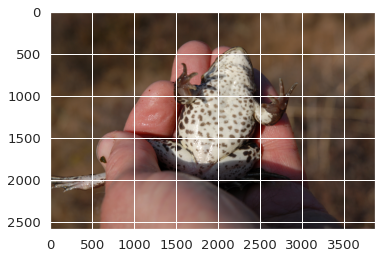

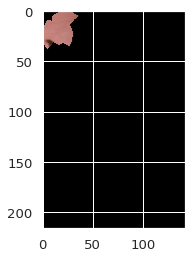

In [53]:
# locC_2007_spring_00345_0238
name = "locC_2007_spring_00345_0238"
interesting = [img for img in roi_ds if img["filename"] == name]
for img in interesting:
    display_cv2_image(cv2.imread("frog_photos/locC_2007_spring_00345_0238.jpg"))
    display_cv2_image(img["roi"])

locA_2013_spring_0475_0024
0024


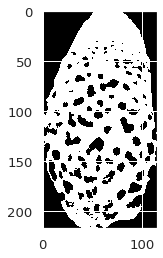

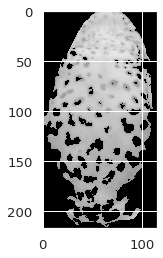

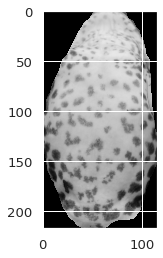

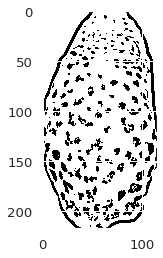

In [68]:
# Display example of roi
name = "locA_2013_spring_0475_0024"
sample = [img for img in roi_ds if img["filename"] == name]
if sample:
    sample = sample[0]
else:
    raise  Exception("File not in training set")
print(sample["filename"])
print(sample["frog_id"])
hihi = sample["roi"]
hihi = cv2.cvtColor(hihi, cv2.COLOR_BGR2GRAY)
hihi = cv2.medianBlur(hihi, 1)
hihi = cv2.adaptiveThreshold(hihi, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 1)
display_cv2_image(hihi)

# Display example of roi
hihi = sample["roi"]
hihi = cv2.cvtColor(hihi, cv2.COLOR_BGR2GRAY)
hihi = cv2.medianBlur(hihi, 1)
_, hihi = cv2.threshold(hihi,150,255,cv2.THRESH_TOZERO)
display_cv2_image(hihi)

hihi = sample["roi"]
hihi = cv2.cvtColor(hihi, cv2.COLOR_BGR2GRAY)
#hihi = cv2.equalizeHist(hihi)
hihi = cv2.medianBlur(hihi, 1)
#hihi = cv2.adaptiveThreshold(hihi, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 1)
#_, hihi = cv2.threshold(hihi, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
display_cv2_image(hihi)

hihi = sample["roi"]
hihi = cv2.cvtColor(hihi, cv2.COLOR_BGR2GRAY)
#min_intensity = np.min(hihi)
#max_intensity = np.max(hihi)
#hihi = ((hihi - min_intensity) / (max_intensity - min_intensity)) * 255
#hihi = hihi.astype(np.uint8)
hihi = cv2.medianBlur(hihi, 1)
hihi = cv2.adaptiveThreshold(hihi, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 10)
#_, hihi = cv2.threshold(hihi, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
display_cv2_image(hihi)

In [69]:
"""
# Apply grascale + blur filtering
"""
for item in roi_ds:
    item["roi"] = apply_grayscale_and_filter(item["roi"])

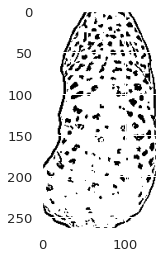

In [70]:
# Display example of roi
display_cv2_image(roi_ds[0]["roi"])

In [71]:
def _image_matcher(args):
    matcher_name, sample1, sample2 = args

    detector = Matcher()

    s_name_1 = sample1["filename"]
    s_name_2 = sample2["filename"]
    s_frog_id_1 = sample1["frog_id"]
    s_frog_id_2 = sample2["frog_id"]


    num_matches, matches, mean_distance, kpt1, kpt2 = detector.detect(sample1["roi"], sample2["roi"])

    return dict(
        sample_1=s_name_1,
        sample_2=s_name_2,
        match_count=num_matches,
        sample_1_id=s_frog_id_1,
        sample_2_id=s_frog_id_2,
        mean_distance=mean_distance
    )


with mp.Pool(processes=os.cpu_count()) as pool:
    data_comb = list(itertools.combinations(roi_ds, r=2))
    data_comb = [[args.matcher] + list(x) for x in data_comb]

    mp_results: list = list(tqdm(pool.imap(_image_matcher,  data_comb), desc="Performing matching for all samples.", total=len(data_comb)))

Performing matching for all samples.: 100%|██████████| 286146/286146 [03:22<00:00, 1411.55it/s]


In [72]:

results = {}
for res in tqdm(mp_results, desc="Transforming results from multiprocessing to map structure"):

    if res["sample_1"] not in results:
        results[res["sample_1"]] = []
    if res["sample_2"] not in results:
        results[res["sample_2"]] = []

    results[res["sample_1"]].append((
        (res["sample_2_id"], res["match_count"], res["sample_2"], res["mean_distance"])
    ))
    results[res["sample_2"]].append((
        (res["sample_1_id"], res["match_count"], res["sample_1"], res["mean_distance"])
    ))


Transforming results from multiprocessing to map structure: 100%|██████████| 286146/286146 [00:00<00:00, 399092.24it/s]


In [73]:
print(len(results[list(results.keys())[0]]))

756


# Load and Preprocess Test Images

In [74]:
results2 = results.copy()
# Sort matches and "classify" with the one having most matches.
for k in tqdm(results.keys()):
    if args.mean_distance:
        results2[k] = sorted(results2[k], key=lambda x: x[3], reverse=False)[0]
    else:
        results2[k] = sorted(results2[k], key=lambda x: x[1], reverse=True)[0]


100%|██████████| 757/757 [00:00<00:00, 3120.90it/s]


In [75]:
print(list(results.keys())[0])
print(sum([1 for sample_1_name, (sample_2_id, match_count, sample_2_name, average_distance) in results2.items() if "locA_2007_spring_00105_0057" in (sample_1_name, sample_2_name)]))

01420_locN_2008_fall_0164
1


In [76]:
"""
Print best matching data
"""
samples_dir = pathlib.Path("./match_samples")
samples_dir.mkdir(exist_ok=True)
save_images = True

if save_images:
    for sample_1_name, (sample_2_id, match_count, sample_2_name, average_distance) in tqdm(results2.items()):

        # Retrieve rois from roi_dataset
        s_1, s_2 = list(filter(lambda x: x["filename"] in [sample_1_name, sample_2_name], roi_ds))


        s_name_1 = s_1["filename"]
        s_name_2 = s_2["filename"]
        s_frog_id_1 = s_1["frog_id"]
        s_frog_id_2 = s_2["frog_id"]


        # Matching
        detector = Matcher()
        num_matches, matches, mean_distance, kpt1, kpt2 = detector.detect(s_1["roi"], s_2["roi"])


        actual_frog_id = sample_1_name.split("_")[-1]
        prediction_frog_id = sample_2_id

        if actual_frog_id == prediction_frog_id:
            image_save_path = samples_dir.joinpath("correct")
        else:
            image_save_path = samples_dir.joinpath("incorrect")

        image_save_path.mkdir(exist_ok=True)

        save_path = str(image_save_path.joinpath(f"{s_name_1}-{s_name_2}_{s_frog_id_1}-{s_frog_id_2}.jpg").absolute())

        img3 = detector.draw_matches(s_1["roi"], kpt1, s_2["roi"], kpt2, matches)

        cv2.imwrite(save_path, img3)

else:
    save_path = None




100%|██████████| 757/757 [00:04<00:00, 164.16it/s]


# Calculate Success Rate

In [77]:
"""
# Plot final results
"""
n_frog_individuals = len(frog_ids)
cf_matrix = np.zeros((n_frog_individuals, n_frog_individuals), dtype=int)

success_rate = 0.0
for filename, prediction in tqdm(results2.items(), desc="Populating confusion matrix"):
    actual_frog_id = filename.split("_")[-1]
    prediction_frog_id = prediction[0]

    if actual_frog_id == prediction_frog_id:
        success_rate += 1.0

print(success_rate / len(results2))


cf_matrix[frog_ids_map[actual_frog_id]][frog_ids_map[prediction_frog_id]] += 1

df = pd.DataFrame(cf_matrix, columns=frog_ids_map, index=frog_ids_map)

Populating confusion matrix: 100%|██████████| 757/757 [00:00<00:00, 255828.55it/s]

0.33553500660501984


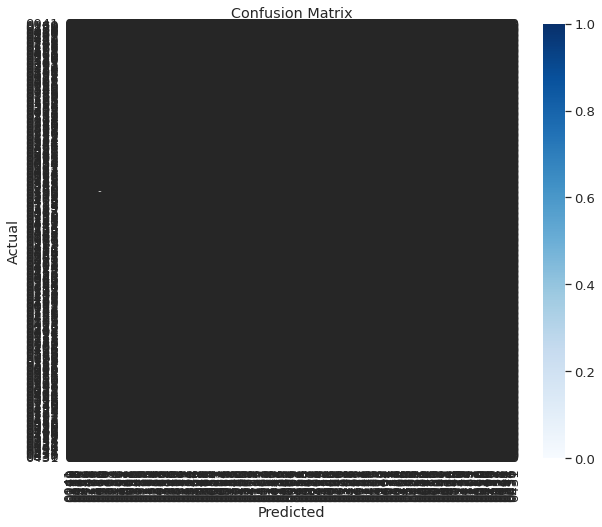

In [78]:

# Create a list of frog labels from the frog_ids_map dictionary
frog_labels = sorted(frog_ids_map.keys(), key=lambda x: frog_ids_map[x])

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
ax = sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=frog_labels, yticklabels=frog_labels)

# Set labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the confusion matrix
plt.show()


In [21]:
heatmap_figure = sns.heatmap(df, annot=True)


In [22]:
figure = heatmap_figure.get_figure()
figure.savefig('svm_conf.png', dpi=400)


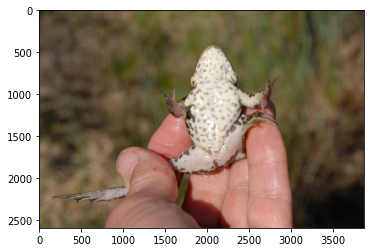

In [18]:
%matplotlib inline

#Import image
image = cv2.imread("frog_photos/00801_locB_2008_spring_0083.jpg")

def display_cv2_image(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #Show the image with matplotlib
    plt.imshow(image)
    plt.show()
